In [86]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from scipy.interpolate import NearestNDInterpolator
from sklearn.preprocessing import MinMaxScaler

In [87]:
def resample_img(img):
    scaler = MinMaxScaler()
    label_arr = np.array(img, dtype=np.float32)
    x,y,z = img.shape
    return np.array(scaler.fit_transform(label_arr.reshape(-1, 1))).reshape(x,y,z)

In [88]:
mask = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_brainmask.nii.gz'

LR_input1 = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_t1_LR.nii.gz'
LR_input2 = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_t2_LR.nii.gz'
GT_input1 = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_t1.nii.gz'
GT_input2 = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_t2.nii.gz'

CT1_only = 'BRATS/BraTS19_CBICA_ANI_1/NeRF_BRATS_MICCAI_subid-BraTS19_CBICA_ANI_1_ct1LR-t1_LR_ct2LR-t2_LR_s_12_shuf_True__CT2_ONLY__FF_256_4.0_1.0__MLP2__NUML_4_N_1024_D_0.0__MSELoss__1.0__1.0__Adam_0.0004__e49__ct2.nii.gz'
CT2_only = 'BRATS/BraTS19_CBICA_ANI_1/NeRF_BRATS_MICCAI_subid-BraTS19_CBICA_ANI_1_ct1LR-t1_LR_ct2LR-t2_LR_s_12_shuf_True__CT1_ONLY__FF_256_4.0_1.0__MLP2__NUML_4_N_1024_D_0.0__MSELoss__1.0__1.0__Adam_0.0004__e49__ct1.nii.gz'

mlp_ct2 = 'BRATS/BraTS19_CBICA_ANI_1/NeRF_BRATS_MICCAI_subid-BraTS19_CBICA_ANI_1_ct1LR-t1_LR_ct2LR-t2_LR_s_12_shuf_True__FF_256_4.0_1.0__MLP2__NUML_4_N_1024_D_0.0__MSELoss__1.0__1.0__Adam_0.0004__e49__ct1.nii.gz'
mlp_ct1 = 'BRATS/BraTS19_CBICA_ANI_1/NeRF_BRATS_MICCAI_subid-BraTS19_CBICA_ANI_1_ct1LR-t1_LR_ct2LR-t2_LR_s_12_shuf_True__FF_256_4.0_1.0__MLP2__NUML_4_N_1024_D_0.0__MSELoss__1.0__1.0__Adam_0.0004__e49__ct2.nii.gz'

img_lr1 = nib.load(LR_input1)
img_lr2 = nib.load(LR_input2)
img_gt1 = nib.load(GT_input1)
img_gt2 = nib.load(GT_input2)

img_ct1_only = nib.load(CT2_only)
img_ct2_only = nib.load(CT1_only)

img_ct1_mlp = nib.load(mlp_ct1)
img_ct2_mlp = nib.load(mlp_ct2)

In [89]:
def get_coord(image):

    img_header = image.header
    img_data = image.get_fdata()
    img_affine = image.affine

    (x, y, z) = image.shape

    label= []
    coordinates = []

    for i in range(x):
        for j in range(y):
            for k in range(z):
                coordinates.append(nib.affines.apply_affine(img_affine, np.array(([i, j, k]))))
                label.append(img_data[i, j, k])
                
    return coordinates, label


In [90]:
c1, l1 = get_coord(img_lr1)
c2, l2 = get_coord(img_lr2)

In [91]:
gt1, _ = get_coord(img_gt1)

In [92]:
xmin, xmax = np.min(np.array(gt1)[:,0]), np.max(np.array(gt1)[:,0])
ymin, ymax = np.min(np.array(gt1)[:,1]), np.max(np.array(gt1)[:,1])
zmin, zmax = np.min(np.array(gt1)[:,2]), np.max(np.array(gt1)[:,2])

x_len = int(np.abs(xmax - xmin))
y_len = int(np.abs(ymax - ymin))
z_len = int(np.abs(zmax - zmin))

In [93]:
X = np.linspace(xmin, xmax, x_len+1)
Y = np.linspace(ymin, ymax, y_len+1)
Z = np.linspace(zmin, zmax, z_len+1)

In [94]:
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import CubicSpline

X, Y, Z = np.meshgrid(X, Y, Z)
interp1 = NearestNDInterpolator(c1, l1)
res1 = interp1(X, Y, Z)
interp2 = NearestNDInterpolator(c2, l2)
res2 = interp2(X, Y, Z)

In [95]:
def crop_array(arr):

    # find the first and last non-zero rows
    first_row = (arr != 0).any(axis=1).argmax()
    last_row = len(arr) - (arr != 0)[::-1].any(axis=1).argmax() - 1

    # find the first and last non-zero columns
    first_col = (arr != 0).any(axis=0).argmax()
    last_col = len(arr[0]) - (arr != 0)[:,::-1].any(axis=0).argmax() - 1

    # slice the array to create a new array with only the non-zero rows and columns
    return arr[first_row:last_row+1, first_col:last_col+1]


In [96]:
import nibabel as nib
import nibabel.processing as nip
import nibabel.orientations as nio


def resample_nib(img, voxel_spacing=(1, 1, 1), order=3):
    """Resamples the nifti from its original spacing to another specified spacing
    
    Parameters:
    ----------
    img: nibabel image
    voxel_spacing: a tuple of 3 integers specifying the desired new spacing
    order: the order of interpolation
    
    Returns:
    ----------
    new_img: The resampled nibabel image 
    
    """
    # resample to new voxel spacing based on the current x-y-z-orientation
    aff = img.affine
    shp = img.shape
    zms = img.header.get_zooms()
    # Calculate new shape
    new_shp = tuple(np.rint([
        shp[0] * zms[0] / voxel_spacing[0],
        shp[1] * zms[1] / voxel_spacing[1],
        shp[2] * zms[2] / voxel_spacing[2]
        ]).astype(int))
    new_aff = nib.affines.rescale_affine(aff, shp, voxel_spacing, new_shp)
    new_img = nip.resample_from_to(img, (new_shp, new_aff), order=order, cval=0)
    print("[*] Image resampled to voxel size:", voxel_spacing)
    return new_img

spline_ct1 = resample_nib(img_lr1, voxel_spacing=(1.0, 1.0, 1.0), order=3)
spline_ct2 = resample_nib(img_lr2, voxel_spacing=(1.0, 1.0, 1.0), order=3)

[*] Image resampled to voxel size: (1.0, 1.0, 1.0)
[*] Image resampled to voxel size: (1.0, 1.0, 1.0)


In [97]:
nn_lr1 = np.flip(np.rot90(res1), axis=0)
nn_lr2 = np.flip(np.rot90(res2), axis=0)

In [118]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
def show_slices(slices, labels, min_error_left, max_error_left, min_error_right, max_error_right):
    """ Function to display row of image slices """
    plt.close()
    fig = plt.figure(figsize=(16, 12))
    fig.set_facecolor('black')  # set the background color to black
    fig.subplots_adjust(left=0.15)
    # Set up grid layout for subplots
    gs = gridspec.GridSpec(nrows=4, ncols=9, figure=fig, wspace=0.025, hspace=0.05)

    # Add axes for each slice
    axes = []
    # for rpws
    for i in range(4):
        row_axes = []
        # Add label to first subplot in each row
        label_ax = fig.add_subplot(gs[i, 0])
        label_ax.axis('off')
        label_ax.text(0.5, 0.5, f"{labels[i]}", ha='center', va='center', rotation=90, fontsize=14, color='white')
        for j in range(1, 9):
            ax = fig.add_subplot(gs[i, j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            # Add a red box to the second column of images
                
            if j == 2:
                rect = patches.Rectangle((55, 70), 25, 25, linewidth=1, edgecolor='y', facecolor='none')
                ax.add_patch(rect)
            
            if j == 3:
                rect = patches.Rectangle((60, 80), 25, 25, linewidth=1, edgecolor='y', facecolor='none')
                ax.add_patch(rect)
            
            if j == 5:
                rect = patches.Rectangle((55, 10), 25, 25, linewidth=1, edgecolor='y', facecolor='none')
                ax.add_patch(rect)
            
            if j == 7:
                rect = patches.Rectangle((125, 70), 25, 25, linewidth=1, edgecolor='y', facecolor='none')
                ax.add_patch(rect)

            row_axes.append(ax)
        axes.append(row_axes)
        
    # Add the slices to the axes
    for i, slice_row in enumerate(slices):
        for j, slice in enumerate(slice_row):
            if j ==3:
                axes[i][j].imshow(slice.T, cmap="hot", origin="lower", vmin=min_error_left, vmax=max_error_left)   
            elif j==7:
                axes[i][j].imshow(slice.T, cmap="hot", origin="lower", vmin=min_error_right, vmax=max_error_right)  
            else:
                axes[i][j].imshow(slice.T, cmap="gray", origin="lower")

    fig.tight_layout()
    plt.savefig("brats.pdf", dpi=500)#,bbox_inches='tight', bbox_extra_artists=[ax], pad_inches=(0, 1, 0, 0.2))

    return fig

<ipython-input-118-6319872c40db>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


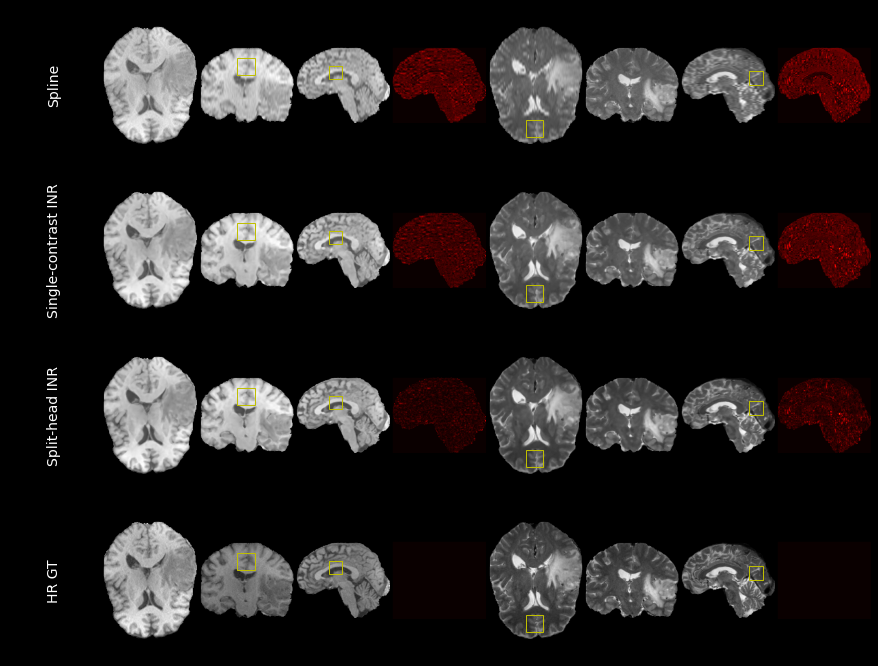

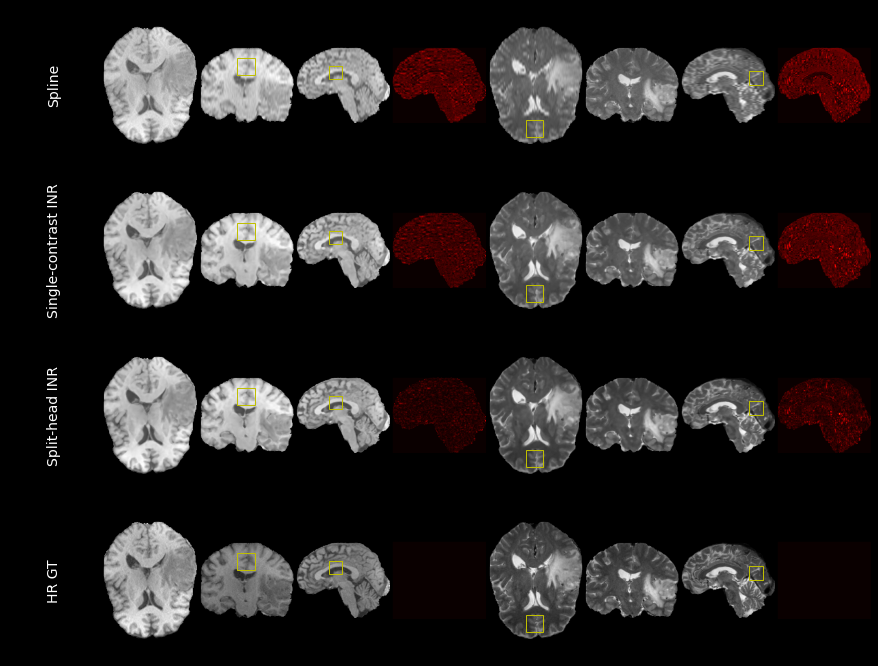

In [119]:
# LR input
mask = 'BRATS/BraTS19_CBICA_ANI_1/BraTS19_CBICA_ANI_1_brainmask.nii.gz'
mask = nib.load(mask).get_fdata()
x_dim, y_dim, z_dim = img_gt1.shape

nn_lr1_ = resample_img(nn_lr1) * mask
nn_lr2_ = resample_img(nn_lr2) * mask
spline_ct1_ = resample_img(spline_ct1.get_fdata()) * mask
spline_ct2_ = resample_img(spline_ct2.get_fdata()) * mask

# gt

gtsag1 = np.array(resample_img(img_gt1.get_fdata())*mask)[int(x_dim/2), :, :]
gtcor1 = np.array(resample_img(img_gt1.get_fdata())*mask)[:, int(y_dim/2), :]
gtax1 = np.array(resample_img(img_gt1.get_fdata())*mask)[:, :, int(z_dim/2)]

gtsag2 = np.array(resample_img(img_gt2.get_fdata())*mask)[int(x_dim/2), :, :]
gtcor2 = np.array(resample_img(img_gt2.get_fdata())*mask)[:, int(y_dim/2), :]
gtax2 = np.array(resample_img(img_gt2.get_fdata())*mask)[:, :, int(z_dim/2)]

slice5 = [gtax1, gtcor1, gtsag1, np.zeros((gtsag1.shape)), gtax2, gtcor2, gtsag2, np.zeros((gtsag2.shape))]
slice5 = [crop_array(i) for i in slice5]


## LR
sag1a = nn_lr1_[int(x_dim/2), :, :]
cor1a = nn_lr1_[:, int(y_dim/2), :]
ax1a = nn_lr1_[:, :, int(z_dim/2)]

sag1b = nn_lr2_[int(x_dim/2), :, :]
cor1b = nn_lr2_[:, int(y_dim/2), :]
ax1b = nn_lr2_[:, :, int(z_dim/2)]

err1a = np.abs(sag1a-gtsag1)
err1b =  np.abs(sag1b-gtsag2)

slice1 = [ax1a, cor1a, sag1a,err1a , ax1b, cor1b, sag1b,err1b]
slice1 = [crop_array(i) for i in slice1]


# spline

sag1a = spline_ct1_[int(x_dim/2), :, :]
cor1a = spline_ct1_[:, int(y_dim/2), :]
ax1a = spline_ct1_[:, :, int(z_dim/2)]

sag1b = spline_ct2_[int(x_dim/2), :, :]
cor1b = spline_ct2_[:, int(y_dim/2), :]
ax1b = spline_ct2_[:, :, int(z_dim/2)]

err2a = np.abs(gtsag1-sag1a)
err2b = np.abs(gtsag2-sag1b)

slice2 = [ax1a, cor1a, sag1a,err2a , ax1b, cor1b, sag1b, err2b]
slice2 = [crop_array(i) for i in slice2]
# single contrast only

sag1 = np.array(resample_img(img_ct1_only.get_fdata())*mask)[int(x_dim/2), :, :]
cor1 = np.array(resample_img(img_ct1_only.get_fdata())*mask)[:, int(y_dim/2), :]
ax1 = np.array(resample_img(img_ct1_only.get_fdata())*mask)[:, :, int(z_dim/2)]

sag2 = np.array(resample_img(img_ct2_only.get_fdata())*mask)[int(x_dim/2), :, :]
cor2 = np.array(resample_img(img_ct2_only.get_fdata())*mask)[:, int(y_dim/2), :]
ax2 = np.array(resample_img(img_ct2_only.get_fdata())*mask)[:, :, int(z_dim/2)]

err3a = np.abs(gtsag1-sag1)
err3b = np.abs(gtsag2-sag2)

slice3 = [ax1, cor1, sag1, err3a, ax2,  cor2, sag2, err3b]
slice3 = [crop_array(i) for i in slice3]
# MLP2

sag1 = np.array(resample_img(img_ct2_mlp.get_fdata())*mask)[int(x_dim/2), :, :]
cor1 = np.array(resample_img(img_ct2_mlp.get_fdata())*mask)[:, int(y_dim/2), :]
ax1 = np.array(resample_img(img_ct2_mlp.get_fdata())*mask)[:, :, int(z_dim/2)]

sag2 = np.array(resample_img(img_ct1_mlp.get_fdata())*mask)[int(x_dim/2), :, :]
cor2 = np.array(resample_img(img_ct1_mlp.get_fdata())*mask)[:, int(y_dim/2), :]
ax2 = np.array(resample_img(img_ct1_mlp.get_fdata())*mask)[:, :, int(z_dim/2)]

err4a = np.abs(gtsag1-sag1)
err4b = np.abs(gtsag2-sag2)

slice4 = [ax1, cor1, sag1, err4a, ax2, cor2, sag2, err4b]
slice4 = [crop_array(i) for i in slice4]

min_error_left = min(np.min(err1a), np.min(err2a), np.min(err3a), np.min(err4a))
min_error_right = min(np.min(err1b), np.min(err2b), np.min(err3b), np.min(err4b))
max_error_left = max(np.max(err1a), np.max(err2a), np.max(err3a), np.max(err4a))
max_error_right = max(np.max(err1b), np.max(err2b), np.max(err3b), np.max(err4b))

slices = [slice2, slice3, slice4, slice5] 
labels = ['Spline', 'Single-contrast INR', 'Split-head INR', 'HR GT']

show_slices(slices, labels, min_error_left, max_error_left, min_error_right, max_error_right)